## Projet ML : Classification sur Données LiDAR pour l’Identification de Classes

Ce notebook constitue la première partie d’un projet en deux volets portant sur la modélisation à partir de données LiDAR. Cette première partie est dédiée à la **classification** : notre objectif est de développer et comparer plusieurs modèles de classification pour identifier différentes classes à partir des données LiDAR fournies par le site NEON (National Ecological Observatory Network).

Nous explorerons différentes méthodes de prétraitement, de modélisation, de sélection de caractéristiques et d’évaluation rigoureuse selon les bonnes pratiques du machine learning.

**Binôme :**
- Abdoulaye SAKO
- Mathias LE BAYON

In [1]:
import laspy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# A. Chargement des données

In [2]:
# Charger le fichier .laz
#NEON (National Ecological Observatory Network). Discrete return LiDAR point cloud (DP1.30003.001), provisional data. Dataset accessed from https://data.neonscience.org/data-products/DP1.30003.001 on April 29, 2025. Data archived at [your DOI].
path = "NEON DATA/NEON_D03_OSBS_DP1_401000_3277000_classified_point_cloud_colorized.laz"
las = laspy.read(path) 


# Récupérer le nom des dimensions
cols = list(las.point_format.dimension_names)
print(cols)

# On transforme les données en dictionnaire
data = {}

for dim in list(las.point_format.dimension_names):
    value = getattr(las, dim)
    if not isinstance(value, np.ndarray):
        value = np.array(value)  # Conversion obligatoire si c'est un SubFieldView
    data[dim] = value

# Créer un DataFrame avec les données
df = pd.DataFrame(data)

# Vérification rapide du dataset
df.head()

['X', 'Y', 'Z', 'intensity', 'return_number', 'number_of_returns', 'synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'scan_direction_flag', 'edge_of_flight_line', 'classification', 'user_data', 'scan_angle', 'point_source_id', 'gps_time', 'red', 'green', 'blue']


,X,Y,Z,intensity,return_number,number_of_returns,synthetic,key_point,withheld,overlap,...,scan_direction_flag,edge_of_flight_line,classification,user_data,scan_angle,point_source_id,gps_time,red,green,blue
0,1499095,-2500093,47592,11248,1,1,0,0,0,0,...,1,0,2,0,-749,20,318393.366272,45056,39424,34304
1,1499484,-2500186,47566,11680,1,1,0,0,0,0,...,1,0,2,0,-745,20,318393.366276,53760,48640,46080
2,1499877,-2500280,47527,8832,1,1,0,0,0,0,...,1,0,2,0,-741,20,318393.366280,47104,41984,34816
3,1499990,-2500582,48293,4592,1,1,0,0,0,0,...,0,0,1,8,-709,20,318393.374948,19712,16128,17664
4,1499538,-2500504,47561,10848,1,1,0,0,0,0,...,0,0,2,0,-713,20,318393.374952,57600,53504,48896


# B. Analyse du Dataset

In [4]:
print("Nombre d'observations et de variables :")
print(df.shape)

print("Valeurs distinctes dans la colonne 'classification' :")
print(df['classification'].unique())

# Optionnel : Afficher la fréquence de chaque valeur dans la colonne "classification"
print("\nFréquence des valeurs dans la colonne 'classification' :")
print(df['classification'].value_counts())

Nombre d'observations et de variables :
(16524959, 21)
Valeurs distinctes dans la colonne 'classification' :
[2 1 5 7]

Fréquence des valeurs dans la colonne 'classification' :
classification
2    7689463
5    7444814
1    1390498
7        184
Name: count, dtype: int64


**Voici un résumé des observations présentes dans notre dataset ainsi que leur classe respectives d'après la doc récupéré avec le dataset :**

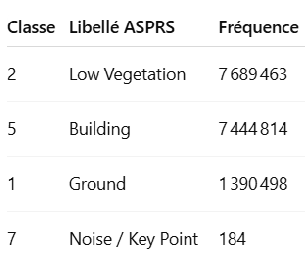

Après s'être intéréssé à la diversité des observations, une première analyse exploratoire essentielle pour guider la sélection des features à débuté. 

Elle permet d’évaluer la corrélation entre les différentes variables du dataset et la variable cible classification. Cela nous aide à identifier les variables les plus informatives pour la prédiction, mais aussi celles qui pourraient introduire un biais si elles sont trop fortement corrélées à la sortie.

In [5]:
#Calculer la matrice de corrélation
corr_matrix = df.corr()

#Afficher la matrice de corrélation
corr_matrix['classification'].sort_values(ascending=False) #Affichage de la corrélation par rapport à classification par ordre décroissant

classification         1.000000
user_data              0.807604
number_of_returns      0.488981
Y                      0.379271
Z                      0.210555
X                      0.171511
return_number          0.095445
scan_angle             0.043521
edge_of_flight_line    0.002159
scan_direction_flag    0.000062
gps_time              -0.134380
point_source_id       -0.137181
green                 -0.377127
red                   -0.465021
blue                  -0.478716
intensity             -0.487223
synthetic                   NaN
key_point                   NaN
withheld                    NaN
overlap                     NaN
scanner_channel             NaN
Name: classification, dtype: float64

On remarque que les colonnes `synthetic`, `key_point`, `withheld`, `overlap`, `scanner_channel` ont comme valeur NaN avec toutes les autres colonnes. On peut donc bien confirmer que les valeurs sur ces colonnes sont constament nulles et donc qu'elles peuvent être supprimé du dataset.

Rappel :
- 1.0 : corrélation parfaite (ex : avec soi-même)

- 0.0 : pas de corrélation

- -1.0 : corrélation inverse parfaite

# C. Préparation du dataset

Le dataset initial étant très volumineux, nous avons choisi de travailler sur un échantillon représentant 1 % des données. Avec plus de 165 000 observations, cet échantillon reste largement suffisant pour entraîner et évaluer efficacement nos modèles de classification tout en réduisant considérablement le temps de traitement.

In [29]:
# Récupération de 1% de la taille de l'échantillon
df_sampled = df.sample(frac=0.01, random_state=42) 

df_sampled.shape

(165250, 21)

On a donc **165 250** observations qui sont classifiées

### 1. Nettoyage du Dataset & data leakage

In [7]:
# On retire les lignes avec classification 6 ou 7 qui correspondent à du bruit
df_clear = df_sampled[~df_sampled['classification'].isin([6, 7])]

# On nettoie le dataset en supprimant les colonnes null
df_clear = df_clear.drop(columns=['synthetic', 'key_point', 'withheld', 'overlap', 'scanner_channel', 'user_data', 'Z']) 

En plus des classifications bruitées, on écarte les colonnes `user_data` et `Z` pour éviter un data leakage dans l'entraînement du modèle. Le data leakage se produit lorsqu'une information utilisée pour entraîner un modèle contient directement (ou indirectement) des indices sur la cible

La variable `Z` représente l’altitude, qui est souvent directement liée à la classe (ex. : sol en bas, végétation en haut) et serait donc triviale à utiliser comme prédicteur si elle est aussi l’élément à estimer. Elle peut ainsi être considérée comme une sortie cible. De même, user_data contient parfois un codage direct ou redondant de la classe (`classification`). Si cette variable permet de déduire la classe sans réellement apprendre à généraliser, elle fausse l’évaluation du modèle. 

Pour garantir une vraie capacité de généralisation, on s’appuie uniquement sur des variables capté depuis le LIDAR.

### 2. Extraction des features : Matrice de corrélation 

La matrice de corrélation permet d’identifier les relations linéaires entre les variables. En particulier, elle aide à repérer les features peu ou non corrélées avec la variable cible.

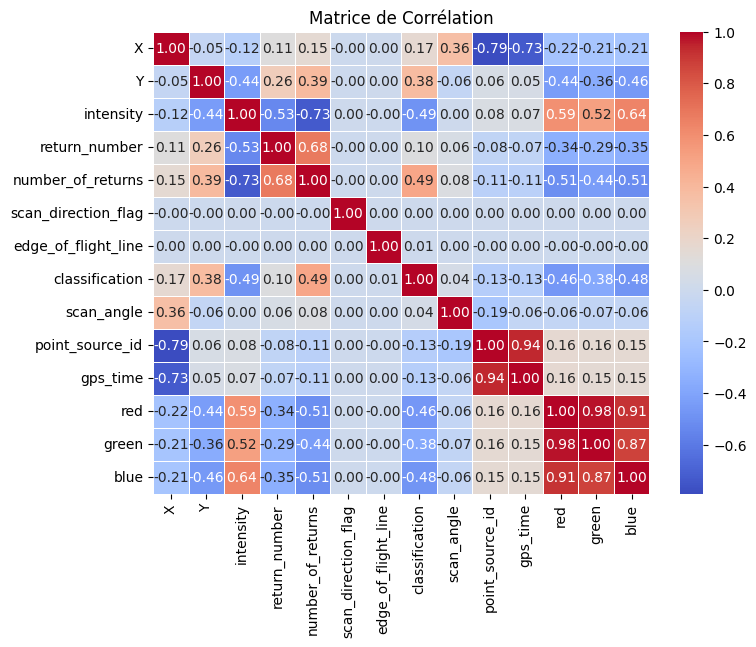

In [8]:
#Calculer la matrice de corrélation
corr_matrix = df_clear.corr()

#Afficher la matrice de corrélation
corr_matrix['classification']

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matrice de Corrélation')
plt.show()

Ici, scan_direction_flag et edge_of_flight_line affichent des corrélations quasi nulles avec les autres variables, ce qui suggère qu’elles n’apportent pas d'information pertinente pour la classification. Elles sont donc retirées pour épurer les données et éviter d’introduire du bruit inutile dans l’entraînement du modèle.

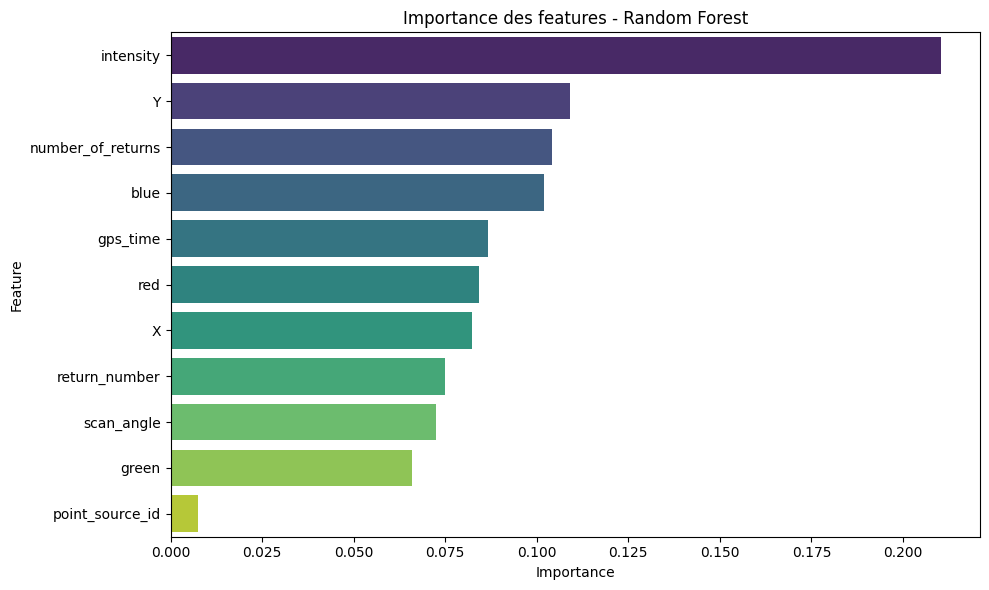

En observant le graphique des importances des variables issu du modèle Random Forest, on constate que `point_source_id` a une contribution négligeable à la prédiction des classes. Son importance est proche de zéro, ce qui indique qu'elle n'apporte quasiment aucune information discriminante au modèle. Pour simplifier l'apprentissage et améliorer potentiellement la généralisation, il est donc pertinent de supprimer cette variable des features utilisées pour l'entraînement.



In [9]:
# On nettoie le dataset en supprimant les variables jugé peu pertinante
df_clear = df_clear.drop(columns=['scan_direction_flag', 'edge_of_flight_line', 'point_source_id']) 

### 3. Normalisation du Dataset

La normalisation permet d’harmoniser les échelles des variables pour améliorer la stabilité des algorithmes de classification. Dans notre cas, un soin particulier a été apporté au choix de la méthode afin de préserver la polarité des données (valeurs positives et négatives), notamment pour les coordonnées GPS, où inverser un signe pourrait fausser la localisation.

In [10]:
# Séparer les colonnes à normaliser et celle à exclure
columns_to_scale = df_clear.columns.drop('classification')

# Créer une copie du DataFrame pour conserver 'classification' non modifiée
df_clear_no_scaled = df_clear.copy()

# Appliquer la normalisation uniquement sur les colonnes choisies
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_values = scaler.fit_transform(df_clear[columns_to_scale])

# Reconstituer le DataFrame avec les colonnes normalisées
df_scaled = pd.DataFrame(scaled_values, columns=columns_to_scale, index=df_clear.index)

# Ajouter la colonne 'classification' non modifiée
df_scaled['classification'] = df_clear['classification']

# Remplacer l'ancien DataFrame si nécessaire
df_clear = df_scaled

# Vérification
df_clear.head(10)


,X,Y,intensity,return_number,number_of_returns,scan_angle,gps_time,red,green,blue,classification
15607492,0.232264,0.249125,-0.779753,-1.000000,-1.000000,0.140127,-0.331927,-0.246032,-0.352697,-0.596838,2
13411789,0.484003,0.962305,-0.991605,-0.714286,-0.142857,0.739938,-0.981299,-0.166667,-0.170124,-0.470356,5
15405519,0.071487,0.389203,-0.938765,-0.714286,-0.142857,-0.067169,-0.332923,-0.182540,-0.161826,-0.343874,5
5075460,-0.048510,0.163040,-0.647901,-1.000000,-1.000000,-0.658097,-0.091404,0.325397,0.087137,-0.177866,2
10186435,0.328935,-0.219589,-0.577778,-1.000000,-1.000000,0.264773,-0.326701,0.547619,0.344398,0.083004,2
4357312,-0.053445,0.161558,-0.577778,-1.000000,-1.000000,-0.221699,-0.330447,0.611111,0.427386,-0.019763,2
7548878,-0.972500,0.750983,-0.982222,-1.000000,-0.714286,0.735631,0.983115,-0.325397,-0.460581,-0.343874,1
7087633,-0.676835,0.859848,-0.876049,-0.428571,-0.428571,0.091668,-0.084462,0.222222,0.136929,-0.304348,2
10635048,0.834134,-0.546608,-0.934321,-0.714286,-0.428571,0.902275,-0.324247,-0.166667,-0.278008,-0.375494,5
16313489,0.173750,0.540296,-0.867160,-0.714286,-0.428571,-0.931619,-0.088237,0.301587,0.394191,-0.209486,5


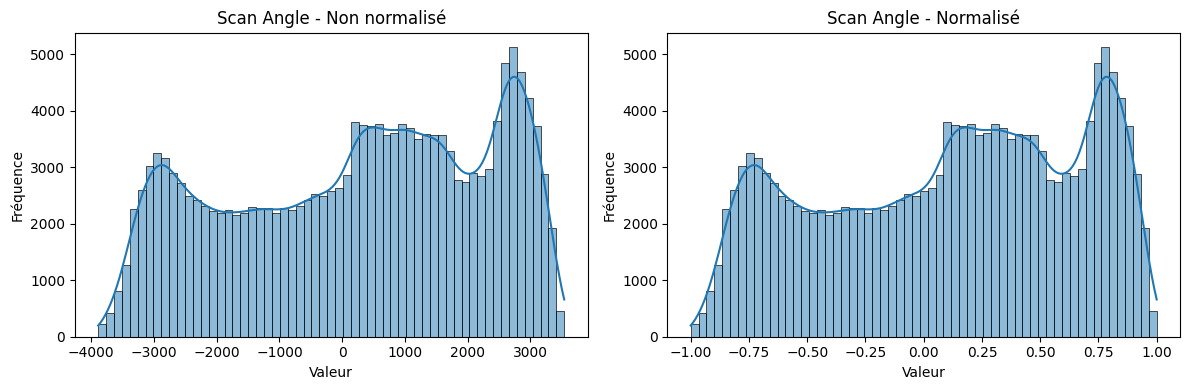

In [11]:
# Création d'une figure avec 1 ligne et 2 colonnes
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # largeur = 12, hauteur = 4

# Premier subplot : scan_angle non normalisé
sns.histplot(df_clear_no_scaled['scan_angle'], kde=True, ax=axes[0])
axes[0].set_title('Scan Angle - Non normalisé')
axes[0].set_xlabel('Valeur')
axes[0].set_ylabel('Fréquence')

# Deuxième subplot : scan_angle normalisé
sns.histplot(df_clear['scan_angle'], kde=True, ax=axes[1])
axes[1].set_title('Scan Angle - Normalisé')
axes[1].set_xlabel('Valeur')
axes[1].set_ylabel('Fréquence')

# Ajustement de l'espacement
plt.tight_layout()
plt.show()


On observe que la distribution de la variable scan_angle est bien conservée après normalisation. L’histogramme garde la même forme globale, simplement rescalée dans l’intervalle [-1, 1]. Cela confirme que la structure des données et leur polarité sont respectées, ce qui est essentiel pour ne pas altérer l’interprétation physique de certaines variables comme les angles ou les positions.

### 4. Équilibrage des données pour corriger un biais du modèle

Le premier modèle de classification étaient fortement biaisés par une surreprésentation de certaines classes, notamment les arbres et les bâtiments, par rapport au sol. Ce déséquilibre faussait l’apprentissage, car le modèle avait tendance à privilégier les classes majoritaires. Pour corriger cela, nous avons augmenté légèrement la taille de l’échantillon, puis rééquilibrer les données en sélectionnant le même nombre d'observations pour chaque classe. L’objectif est d’obtenir une classification plus juste et représentative, en donnant à chaque classe le même poids lors de l'entraînement.



In [12]:
# On identifie le nombre minimum d'observation parmi les classes
minClass = df_clear['classification'].value_counts().min()
print(f"Nombre minimum d'observations observé dans une classe : {minClass}")

# On regroupe les données par classe et on échantillonne minClass lignes par classe
df_balanced = (
    df_clear
    .groupby('classification')
    .apply(lambda x: x.sample(n=minClass, random_state=42))
    .reset_index(drop=True)
)

# Vérification
print(df_balanced['classification'].value_counts())

#Extraction des colonnes utiles et de la sortie
X = df_balanced.drop(columns=['classification'])
y = df_balanced['classification']

Nombre minimum d'observations observé dans une classe : 13710
classification
1    13710
2    13710
5    13710
Name: count, dtype: int64


C:\Users\Mathias Le Bayon\AppData\Local\Temp\ipykernel_15024\4131319552.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clear


# D. Classification

In [13]:
# Division du Dataset echantilloné en train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

### 1. Première Méthode de classification : Random Forest

##### 1.1 Recherche des hyperparamètres pour Random Forest Classifier

<div class='alert alert-warning'>
<b>Attention !</b> La section suivante est très longue à exécuter et n’est pas obligatoire pour la suite du code.
</div>

In [15]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
search_rf = RandomizedSearchCV(rf, param_dist, n_iter=20, cv=3, scoring='accuracy', random_state=42)
search_rf.fit(X_train, y_train)
print("Best RF params:", search_rf.best_params_)


Best RF params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}


##### 1.2 Entraînement du modèle

In [16]:
# Initialiser et entraîner le modèle de classification (Random Forest)
clf = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_depth=None, random_state=42)

clf.fit(X_train, y_train)

# Prédire les classes sur le jeu de test
y_pred_1 = clf.predict(X_test)

# ----- Cross-validation -----
print("Cross-validation en 5 folds...")
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"Scores de CV : {cv_scores}")
print(f"Accuracy moyenne en CV : {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

# Évaluer les performances du modèle
print("Rapport de classification :")
print(classification_report(y_test, y_pred_1))

# Afficher l'accuracy du modèle
accuracy = accuracy_score(y_test, y_pred_1)
print(f"Accuracy : {accuracy:.2f}")

# Appliquer le modèle pour prédire les classes de tous les points
df_balanced['predicted_classification_DT'] = clf.predict(X)

Cross-validation en 5 folds...
Scores de CV : [0.82105519 0.82020423 0.82166302 0.82190615 0.81242402]
Accuracy moyenne en CV : 0.82 ± 0.00
Rapport de classification :
              precision    recall  f1-score   support

           1       0.78      0.79      0.79      1383
           2       0.89      0.83      0.86      1345
           5       0.79      0.83      0.81      1385

    accuracy                           0.82      4113
   macro avg       0.82      0.82      0.82      4113
weighted avg       0.82      0.82      0.82      4113

Accuracy : 0.82


C:\Users\Mathias Le Bayon\AppData\Local\Temp\ipykernel_17412\1098371665.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')


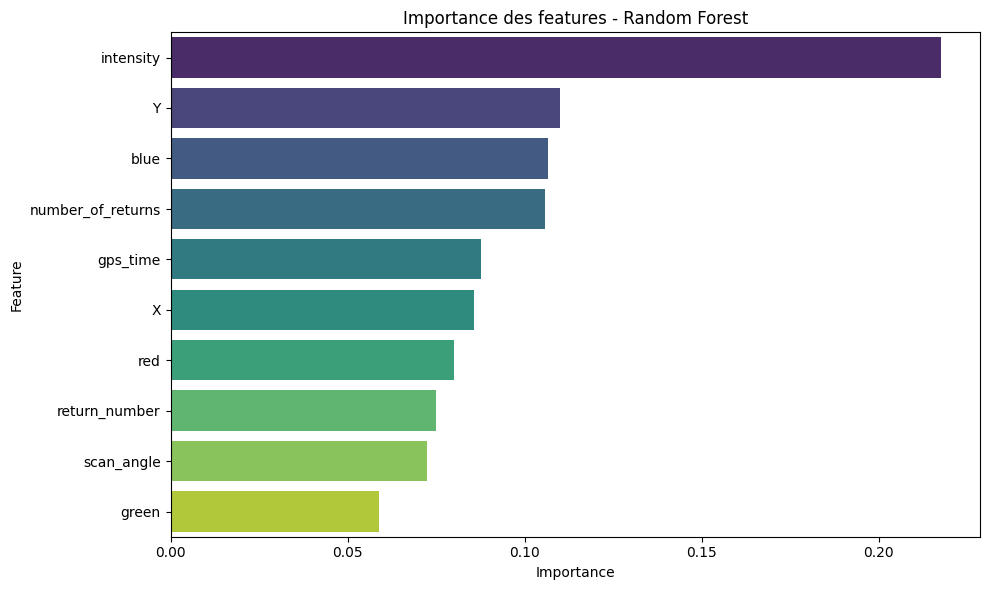

In [ ]:
# Récupérer les features les plus importantes
importances = clf.feature_importances_
feature_names = X.columns  # Assure-toi que X est un DataFrame avec des noms de colonnes
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Trier par importance décroissante
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Affichage
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Importance des features - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


##### 1.3 Matrice de confusion

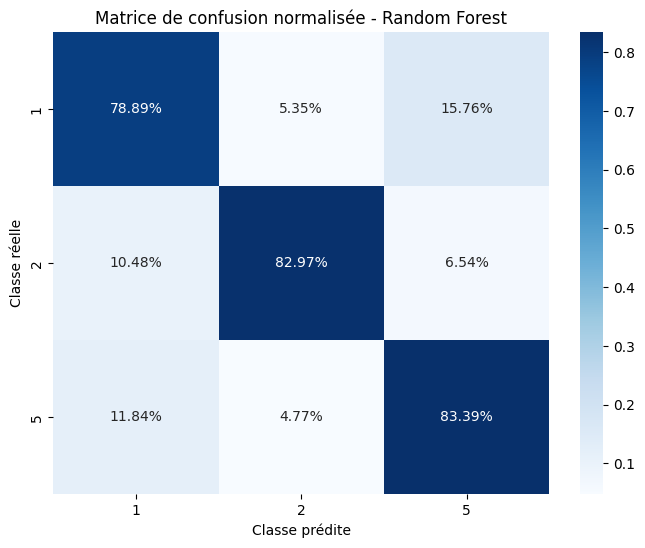

In [17]:
# 2. Matrice de confusion normalisée (en pourcentage)
cm_normalized = confusion_matrix(y_test, y_pred_1, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Matrice de confusion normalisée - Random Forest")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()


### 2. Seconde Méthode de classification : LightGBMClassifier

##### 2.1 Recherche des hyperparamètres pour Ligth GBM

<div class='alert alert-warning'>
<b>Attention !</b> La section suivante est très longue à exécuter et n’est pas obligatoire pour la suite du code.
</div>

In [ ]:
param_dist = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

lgbm = LGBMClassifier(random_state=42)
search_lgbm = RandomizedSearchCV(lgbm, param_dist, n_iter=50, cv=3, scoring='accuracy', random_state=42)
search_lgbm.fit(X_train, y_train)
print("Best LGBM params:", search_lgbm.best_params_)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1920
[LightGBM] [Info] Number of data points in the train set: 24678, number of used features: 10
[LightGBM] [Info] Start training from score -1.099585
[LightGBM] [Info] Start training from score -1.096548
[LightGBM] [Info] Start training from score -1.099707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1918
[LightGBM] [Info] Number of data points in the train set: 24678, number of used features: 10
[LightGBM] [Info] Start training from score -1.099585
[LightGBM] [Info] Start training from score -1.096548
[LightGBM] [Info] Start training from score -1.099707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000864 sec

##### 2.2 Entraînement du modèle

In [18]:
# Initialiser et entraîner le modèle de classification (LightGBM)
clf = LGBMClassifier(num_leaves=31, n_estimators=300, max_depth=10, learning_rate=0.05, random_state=42)

clf.fit(X_train, y_train)

# Prédire les classes sur le jeu de test
y_pred_3 = clf.predict(X_test)

# ----- Cross-validation -----
print("Cross-validation en 5 folds...")
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"Scores de CV : {cv_scores}")
print(f"Accuracy moyenne en CV : {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

# Évaluer les performances du modèle
print("Rapport de classification :")
print(classification_report(y_test, y_pred_3))

# Afficher l'accuracy du modèle
accuracy = accuracy_score(y_test, y_pred_3)
print(f"Accuracy : {accuracy:.2f}")

# Appliquer le modèle pour prédire les classes de tous les points
df_balanced['predicted_classification_LGBC'] = clf.predict(X)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1925
[LightGBM] [Info] Number of data points in the train set: 37017, number of used features: 10
[LightGBM] [Info] Start training from score -1.099585
[LightGBM] [Info] Start training from score -1.096507
[LightGBM] [Info] Start training from score -1.099748
Cross-validation en 5 folds...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1924
[LightGBM] [Info] Number of data points in the train set: 32904, number of used features: 10
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[Li

##### 2.3 Matrice de confusion

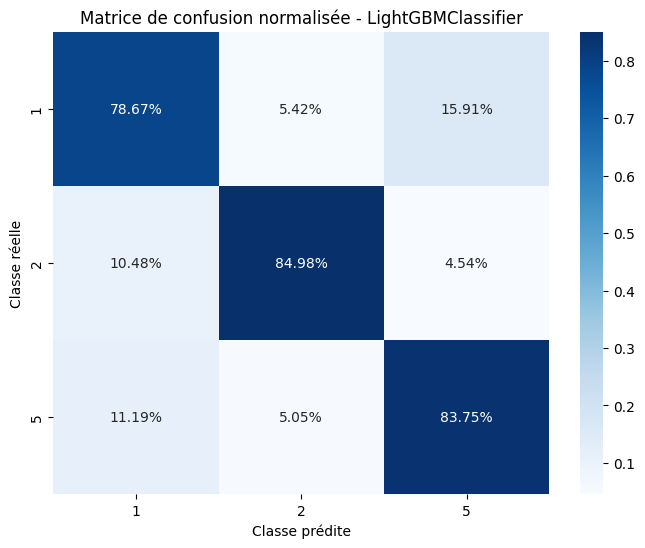

In [19]:
# 2. Matrice de confusion normalisée (en pourcentage)
cm_normalized = confusion_matrix(y_test, y_pred_3, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Matrice de confusion normalisée - LightGBMClassifier")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

### 3. Troisième Méthode de classification : MLPClassifier

##### 3.1 Recherche des hyperparamètres pour MLP Classifier

<div class='alert alert-warning'>
<b>Attention !</b> La section suivante est très longue à exécuter et n’est pas obligatoire pour la suite du code.
</div>

In [ ]:
param_dist = {
    'hidden_layer_sizes': [(100,), (100, 50), (50, 25)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

mlp = MLPClassifier(max_iter=500, random_state=42)
search_mlp = RandomizedSearchCV(mlp, param_dist, n_iter=20, cv=3, scoring='accuracy', random_state=42)
search_mlp.fit(X_train, y_train)
print("Best MLP params:", search_mlp.best_params_)


c:\python\E4\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\python\E4\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\python\E4\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\python\E4\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\python\E4\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: Convergenc

Best MLP params: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 50), 'alpha': 0.001, 'activation': 'tanh'}


##### 3.2 Entraînement du modèle

In [20]:
# --- Initialisation du modèle ---
clf = MLPClassifier(solver='adam', learning_rate='adaptive', hidden_layer_sizes=(100, 50), alpha=0.001, activation='tanh', max_iter=500, random_state=42)

# --- Entraînement ---
clf.fit(X_train, y_train)

# --- Prédiction sur le jeu de test ---
y_pred_4 = clf.predict(X_test)

# --- Cross-validation ---
print("Cross-validation en 5 folds...")
cv_scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"Scores de CV : {cv_scores}")
print(f"Accuracy moyenne en CV : {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

# --- Évaluation du modèle ---
print("\nRapport de classification :")
print(classification_report(y_test, y_pred_4))

accuracy = accuracy_score(y_test, y_pred_4)
print(f"Accuracy sur le test set : {accuracy:.2f}")

# --- Prédiction sur toutes les données ---
df_balanced['predicted_classification_NN'] = clf.predict(X)


Cross-validation en 5 folds...


c:\python\E4\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Scores de CV : [0.81680039 0.81911014 0.82239241 0.82287868 0.82214928]
Accuracy moyenne en CV : 0.82 ± 0.00

Rapport de classification :
              precision    recall  f1-score   support

           1       0.78      0.79      0.79      1383
           2       0.90      0.84      0.87      1345
           5       0.80      0.84      0.82      1385

    accuracy                           0.82      4113
   macro avg       0.83      0.82      0.82      4113
weighted avg       0.83      0.82      0.82      4113

Accuracy sur le test set : 0.82


##### 3.3 Matrice de confusion

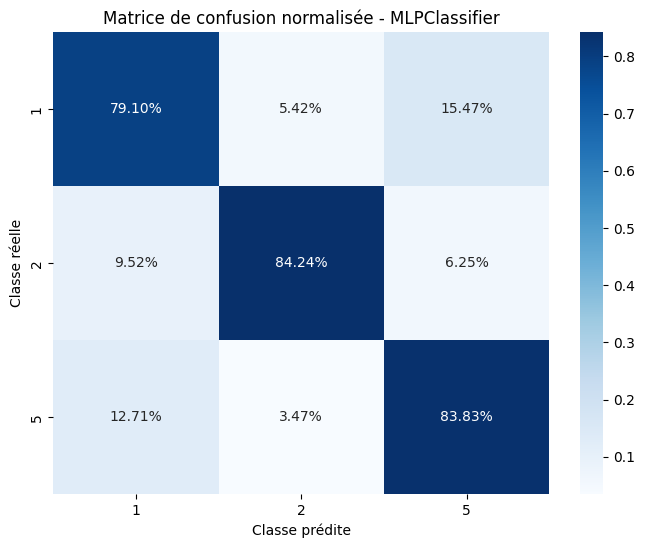

In [21]:
# 2. Matrice de confusion normalisée (en pourcentage)
cm_normalized = confusion_matrix(y_test, y_pred_4, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Matrice de confusion normalisée - MLPClassifier")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

### 4. Quatrième Méthode de classification : Voting Classifier hard & soft

##### 4.1 Entraînement du modèle

In [30]:
# Initialisation des modèles
rf = RandomForestClassifier(random_state=42, n_estimators=100)
lgbm = LGBMClassifier(random_state=42)
mlp = MLPClassifier(random_state=42, max_iter=300, hidden_layer_sizes=(100, 50))

# -----------------------------------------------------
#               Voting Classifier soft
# -----------------------------------------------------

voting_clf_sft = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_depth=None, random_state=42)),
        ('lgbm', LGBMClassifier(num_leaves=31, n_estimators=300, max_depth=10, learning_rate=0.05, random_state=42)),
        ('mlp', MLPClassifier(solver='adam', learning_rate='adaptive', hidden_layer_sizes=(100, 50), alpha=0.001, activation='tanh', max_iter=500, random_state=42))
    ],
    voting='soft',
)

# Entraînement
voting_clf_sft.fit(X_train, y_train)

# Prédiction
y_pred_5 = voting_clf_sft.predict(X_test)

# Évaluation
print("Accuracy VotingClassifier :", accuracy_score(y_test, y_pred_5))

# Prédiction sur toutes les données avec le VotingClassifier soft 
df_balanced['predicted_classification_VotingSoft'] = voting_clf_sft.predict(X) 

# -----------------------------------------------------
#               Voting Classifier hard
# -----------------------------------------------------

voting_clf_hard = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_depth=None, random_state=42)),
        ('lgbm', LGBMClassifier(num_leaves=31, n_estimators=300, max_depth=10, learning_rate=0.05, random_state=42)),
        ('mlp', MLPClassifier(solver='adam', learning_rate='adaptive', hidden_layer_sizes=(100, 50), alpha=0.001, activation='tanh', max_iter=500, random_state=42))
    ],
    voting='hard',
)

# Entraînement
voting_clf_hard.fit(X_train, y_train)

# Prédiction
y_pred_6 = voting_clf_hard.predict(X_test)

# Évaluation
print("Accuracy VotingClassifier :", accuracy_score(y_test, y_pred_6))


# Prédiction sur toutes les données avec le VotingClassifier hard 
df_balanced['predicted_classification_VotingHard'] = voting_clf_hard.predict(X)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1925
[LightGBM] [Info] Number of data points in the train set: 37017, number of used features: 10
[LightGBM] [Info] Start training from score -1.099585
[LightGBM] [Info] Start training from score -1.096507
[LightGBM] [Info] Start training from score -1.099748
Accuracy VotingClassifier : 0.8298079260880136
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1925
[LightGBM] [Info] Number of data points in the train set: 37017, number of used features: 10
[LightGBM] [Info] Start training from score -1.099585
[LightGBM] [Info] Start training from score -1.096507
[LightGBM] [Info] Start training from score -1.099748
Accuracy VotingClassifier : 0.8273766107464138


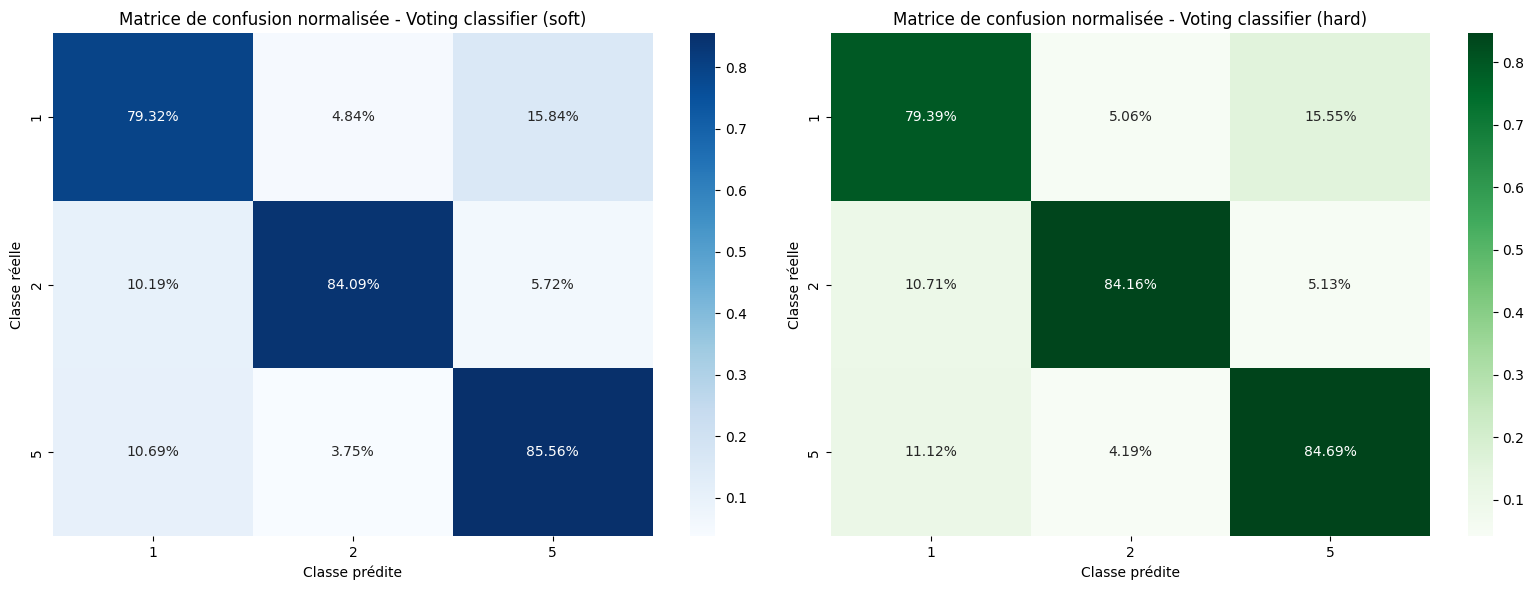

In [23]:
# Matrices de confusion normalisées
cm_soft = confusion_matrix(y_test, y_pred_5, normalize='true')
cm_hard = confusion_matrix(y_test, y_pred_6, normalize='true')

plt.figure(figsize=(16, 6))

# Subplot 1 (soft voting) - position 121
plt.subplot(121)
sns.heatmap(cm_soft, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Matrice de confusion normalisée - Voting classifier (soft)")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")

# Subplot 2 (hard voting) - position 122
plt.subplot(122)
sns.heatmap(cm_hard, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Matrice de confusion normalisée - Voting classifier (hard)")
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")

plt.tight_layout()
plt.show()


# E. Bilan des Méthodes de Classification

Les résultats des classifieurs Voting (hard et soft) sont illustrés dans la figure ci-dessus. On y observe des performances globalement satisfaisantes pour les trois classes étudiées. La classe 5 (végétation haute) est la mieux reconnue, avec des taux de précision supérieurs à 85 % dans les deux cas. De même, la classe 2 (végétation basse) présente une excellente reconnaissance.

En revanche, la classe 1 (sol nu) reste la moins bien prédite, avec un taux de précision avoisinant les 79 %, et une confusion notable avec la classe 5. Cette difficulté peut s’expliquer par une proximité spectrale ou altimétrique entre certaines zones de sol et de végétation, mais également par des caractéristiques moins discriminantes pour cette classe dans les features utilisées.

Lorsque l’on compare les performances à travers le F1-score (voir figure suivante), on constate que malgré nos efforts pour maximiser la diversité des modèles (Random Forest, LGBM, MLP), les performances restent très similaires entre les différentes approches. Cela laisse penser que :
- Les modèles apprennent sur des patterns similaires.
- Ou que les features extraites sont limitées en capacité de discrimination supplémentaire.
- Et que le gros du gain de performance a déjà été atteint par les modèles testés.

Une amélioration notable passerait probablement par une augmentation de la diversité des données, ou par l’introduction de nouvelles features plus informatives (e.g., texture, indices multispectraux, métriques de voisinage, etc.).





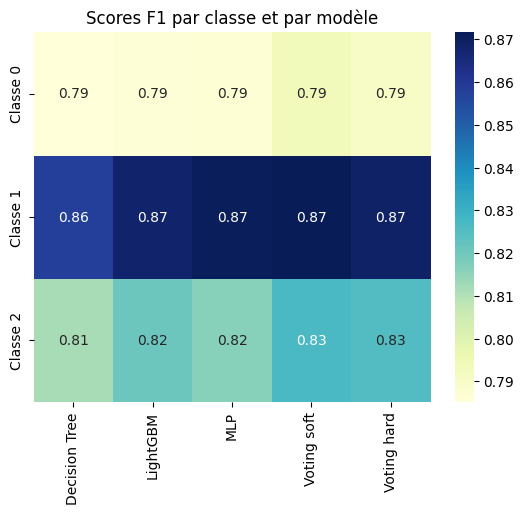

In [25]:
from sklearn.metrics import f1_score


# Exemple : scores F1 par classe
f1_scores = {
    'Decision Tree': f1_score(y_test, y_pred_1, average=None),
    'LightGBM': f1_score(y_test, y_pred_3, average=None),
    'MLP': f1_score(y_test, y_pred_4, average=None),
    'Voting soft': f1_score(y_test, y_pred_5, average=None),
    'Voting hard': f1_score(y_test, y_pred_6, average=None),
}

# DataFrame pour heatmap
f1_df = pd.DataFrame(f1_scores, index=[f'Classe {i}' for i in range(len(f1_scores['MLP']))])

sns.heatmap(f1_df, annot=True, cmap="YlGnBu")
plt.title("Scores F1 par classe et par modèle")
plt.show()


### Dataset des sorties prédites :

In [32]:
df_predicted = df_balanced[['classification', 
                            'predicted_classification_DT', 
                            'predicted_classification_LGBC', 
                            'predicted_classification_NN', 
                            'predicted_classification_VotingSoft', 
                            'predicted_classification_VotingHard'
                        ]]

df_predicted.head(10)

,classification,predicted_classification_DT,predicted_classification_LGBC,predicted_classification_NN,predicted_classification_VotingSoft,predicted_classification_VotingHard
0,1,1,1,1,1,1
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1
5,1,1,1,1,1,1
6,1,1,1,1,1,1
7,1,1,1,1,1,1
8,1,1,1,1,1,1
9,1,1,1,1,1,1
